
## Heart Econet dynamic segmentation
1. [Import and Install Python Libraries](#1)
2. [Load Dataset](#2)
3. [Transformations](#3)
4. [Model Definition](#4)
5. [Training Parameter Definition](#5)
6. [Training Loop](#6)
7. [Performance Visulization](#7)
8. [Performance on Test](#8)
9. [Save Model](#9)



<a id='1'></a>
<h1 style='background: #87CEEB;padding-top: 20px; border:0; color:midnightblue'><center>***Import and Install Python Libraries***</center></h1>

In [2]:
import sys
!{sys.executable} -m pip install -U numpy
!{sys.executable} -m pip install -U matplotlib
!{sys.executable} -m pip install -U opencv-python
!{sys.executable} -m pip install -U pillow
!{sys.executable} -m pip install -U albumentations
!{sys.executable} -m pip install -U scipy
!{sys.executable} -m pip install -U tqdm
!{sys.executable} -m pip install -U torch


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
import os, csv, random, signal, gc

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import shutil

import albumentations as A
from albumentations import Compose, Resize, HorizontalFlip, Normalize
from albumentations.pytorch import ToTensorV2
from albumentations.pytorch import ToTensorV2


from scipy import ndimage as ndi
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from scipy.ndimage import binary_dilation

In [4]:
training_parameter = {
    "checkpoint_path": "unet_none_checkpoint.pth",
    "final_res_path": "unet_none_final_checkpoint.pth",
    "early_stopping_patience": 12,
    "early_stopping_delta": 0.001,
    "optimizer_lr": 0.0001,
    "lr_scheduler_patience": 5,
    "lr_scheduler_factor": 0.5,
    "lr_scheduler_mode": "max",         
    "lr_scheduler_min_lr": 1e-6,
    "lr_scheduler_threshold": 1e-3,
    "max_num_epochs":200,
    "batch_size":16
}

# Define Transforms

In [5]:
def get_transforms(train=True, mean=(0.0,), std=(1.0,)):  # Use dataset-specific mean/std
    if train:
        return Compose([
            Resize(512, 512),
            # HorizontalFlip(p=0.5),
            Normalize(mean=mean, std=std),
            ToTensorV2()
        ])
    else:
        return Compose([
            Resize(512, 512),
            Normalize(mean=mean, std=std), # Use dataset-specific mean/std
            ToTensorV2()
        ])

# Device configuration

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [7]:
import os
# Make getpass.getuser() succeed by giving a username via env var
os.environ.setdefault("USER", "user")            # any non-empty string is fine
# Also avoid any cache-dir ambiguity
os.environ.setdefault("TORCHINDUCTOR_CACHE_DIR", "/tmp/torchinductor_user")

def seed_everything(seed: int = 42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # cuDNN: turn off heuristics and allow only deterministic kernels
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    # Raise if a nondeterministic op slips in
    torch.use_deterministic_algorithms(True)

seed_everything(42)

<a id='2'></a>
<h1 style='background: #87CEEB;padding-top: 20px; border:0; color:midnightblue'><center>***Load Dataset***</center></h1>

# Set address based on environment

In [8]:
# masks_path = '/workspace/data/camus_extracted/masks/'
# images_path =  '/workspace/data/camus_extracted/images/'

# images_training_path = images_path + 'training'
# masks_training_path = masks_path  + 'training'
# images_validation_path = images_path + 'validation'
# masks_validation_path = masks_path  + 'validation'

# #unity
# images_test_path = images_path + 'testing'
# masks_test_path = masks_path + 'testing'


# # consensus
# images_consensus_path ='/workspace/data/unity-expert-consensus/testing_dataset/images/testing'
# masks_consensus_path = '/workspace/data/unity-expert-consensus/testing_dataset/annotations_binary/testing'

# scan_mask ="/workspace/data/camus_fanshape_masks_resunet_fixed_masks" #fanshape mask


In [9]:
kaggle= False        #kaggle or local
if kaggle:
    masks_path = ''
    images_path = ''
    test_train_val_file_path = ''
    csv_path_mask=''
else:  
    masks_path = '/workspace/data/unity-u4s/labels/'
    images_path =  '/workspace/data/unity-u4s/images/'
    test_train_val_file_path = ''
    csv_path_mask=''


images_training_path = images_path + 'training'
masks_training_path = masks_path  + 'training'
images_validation_path = images_path + 'validation'
masks_validation_path = masks_path  + 'validation'

#unity
images_test_path = images_path + 'testing'
masks_test_path = masks_path + 'testing' #LV mask
scan_mask ="/workspace/projects/general_tests/echocardiography_fanshape_mask_extractor/kaggle/working/predicted_training_masks/unlabeled" #fanshape mask

# consensus
images_consensus_path ='/workspace/data/unity-expert-consensus/testing_dataset/images/testing'
masks_consensus_path = '/workspace/data/unity-expert-consensus/testing_dataset/annotations_binary/testing' #LV mask
scan_mask ="/workspace/data/unity-u4s_fanshape_masks" 

# Image and Masks

In [10]:
def plot_combined_mask_overlay(image_folder, mask_folder, count=8, seed=42, width=112, height=112):
    """
    Plot `count` samples with [Original Image, Mask, Overlay].
    Reads images from `image_folder` and masks from `mask_folder`.
    Assumes mask filenames match image filenames, e.g., `frame.png`.

    Displays:
    - Original image
    - Binary mask
    - Overlay with neon-orange border and 25% mask fill.
    """
    # Get sorted matching image-mask filenames
    image_files = sorted([
        f for f in os.listdir(image_folder) if f.endswith('.png')
    ])
    mask_files = sorted([
        f for f in os.listdir(mask_folder) if f.endswith('.png') and f in image_files
    ])

    # Check for matches
    matched_files = list(set(image_files).intersection(mask_files))
    if len(matched_files) < count:
        raise ValueError(f"Only {len(matched_files)} matching image-mask pairs found, but {count} requested.")

    # Select fixed random samples
    random.seed(seed)
    selected_files = random.sample(matched_files, count)

    # Plotting setup
    fig, axes = plt.subplots(count, 3, figsize=(12, 3 * count))
    if count == 1:
        axes = [axes]

    for i, fname in enumerate(selected_files):
        img_path = os.path.join(image_folder, fname)
        mask_path = os.path.join(mask_folder, fname)

        # Read image and mask
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(cv2.resize(img, (width, height)), cv2.COLOR_BGR2RGB)

        mask = Image.open(mask_path).resize((width, height))
        mask_np = np.array(mask)
        if mask_np.max() > 1:
            mask_np = (mask_np > 127).astype(np.uint8)

        # Mask border detection
        dilated = binary_dilation(mask_np, structure=np.ones((3, 3)))
        border = (dilated & ~mask_np).astype(np.uint8)

        # Overlay creation
        overlay = img_rgb.copy()
        neon_orange = np.array([255, 110, 0], dtype=np.uint8)

        # Inner fill: 25% neon orange
        for c in range(3):
            overlay[:, :, c] = np.where(
                mask_np == 1,
                (0.25 * neon_orange[c] + 0.65 * overlay[:, :, c]).astype(np.uint8),
                overlay[:, :, c]
            )

        # Border: full neon orange
        for c in range(3):
            overlay[:, :, c] = np.where(
                border == 1,
                neon_orange[c],
                overlay[:, :, c]
            )

        # Plot original, mask, and overlay
        axes[i][0].imshow(img_rgb)
        axes[i][0].set_title("Original Frame")
        axes[i][1].imshow(mask_np, cmap='gray')
        axes[i][1].set_title("Mask")
        axes[i][2].imshow(overlay)
        axes[i][2].set_title("Overlay")

        for ax in axes[i]:
            ax.axis('off')

    plt.tight_layout()
    plt.show()


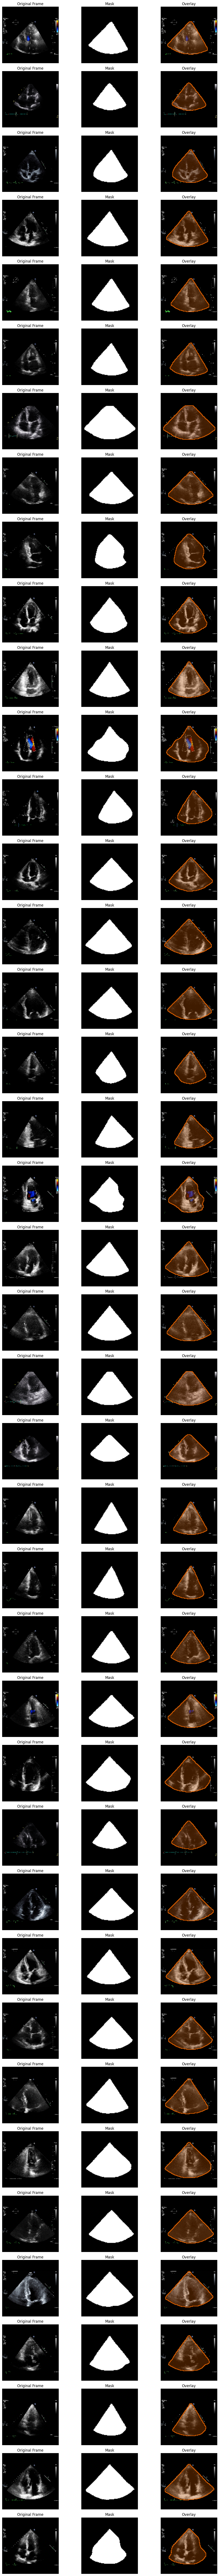

In [11]:
plot_combined_mask_overlay(images_training_path, scan_mask, count=40, seed=42)

# sawp mask if needed

In [12]:
# def plot_combined_mask_overlay_swapped(image_folder, mask_folder, count=8, seed=42, width=112, height=112):
#     """
#     Same as your function, but swaps foreground/background in the mask:
#     - original mask 1 → becomes 0
#     - original mask 0 → becomes 1
#     """
#     # Get sorted matching image-mask filenames
#     image_files = sorted([f for f in os.listdir(image_folder) if f.endswith('.png')])
#     mask_files = sorted([f for f in os.listdir(mask_folder) if f.endswith('.png') and f in image_files])

#     matched_files = list(set(image_files).intersection(mask_files))
#     if len(matched_files) < count:
#         raise ValueError(f"Only {len(matched_files)} matching image-mask pairs found, but {count} requested.")

#     random.seed(seed)
#     selected_files = random.sample(matched_files, count)

#     fig, axes = plt.subplots(count, 3, figsize=(12, 3 * count))
#     if count == 1:
#         axes = [axes]

#     for i, fname in enumerate(selected_files):
#         img_path = os.path.join(image_folder, fname)
#         mask_path = os.path.join(mask_folder, fname)

#         # Image
#         img = cv2.imread(img_path)
#         img_rgb = cv2.cvtColor(cv2.resize(img, (width, height)), cv2.COLOR_BGR2RGB)

#         # Mask
#         mask = Image.open(mask_path).resize((width, height))
#         mask_np = np.array(mask)

#         # Convert to 0/1
#         if mask_np.max() > 1:
#             mask_np = (mask_np > 127).astype(np.uint8)

#         # 🔄 ***SWAP the mask here***
#         mask_np = 1 - mask_np

#         # Border detection
#         dilated = binary_dilation(mask_np, structure=np.ones((3, 3)))
#         border = (dilated & ~mask_np).astype(np.uint8)

#         # Make overlay
#         overlay = img_rgb.copy()
#         neon_orange = np.array([255, 110, 0], dtype=np.uint8)

#         # 25% fill on NEW mask area
#         for c in range(3):
#             overlay[:, :, c] = np.where(
#                 mask_np == 1,
#                 (0.25 * neon_orange[c] + 0.65 * overlay[:, :, c]).astype(np.uint8),
#                 overlay[:, :, c]
#             )

#         # Full neon border
#         for c in range(3):
#             overlay[:, :, c] = np.where(
#                 border == 1,
#                 neon_orange[c],
#                 overlay[:, :, c]
#             )

#         # Plot
#         axes[i][0].imshow(img_rgb)
#         axes[i][0].set_title("Original Frame")

#         axes[i][1].imshow(mask_np, cmap='gray')
#         axes[i][1].set_title("Swapped Mask (1↔0)")

#         axes[i][2].imshow(overlay)
#         axes[i][2].set_title("Overlay (Inverted Mask)")

#         for ax in axes[i]:
#             ax.axis('off')

#     plt.tight_layout()
#     plt.show()


In [13]:
# plot_combined_mask_overlay_swapped(images_training_path, scan_mask, count=20, seed=42)

In [14]:
# import os
# import shutil
# import numpy as np
# from PIL import Image

# def swap_masks_in_folder(mask_dir, output_dir, width=None, height=None):
#     """
#     Reads all masks in mask_dir, swaps foreground/background (1↔0),
#     and saves them into output_dir.
    
#     If output_dir exists, it is deleted and recreated.
#     Masks are saved as PNG files.
    
#     Optional: resize masks to (width, height) before processing.
#     """
    
#     # -------------------------
#     # Remove output folder if exists
#     # -------------------------
#     if os.path.exists(output_dir):
#         shutil.rmtree(output_dir)
#     os.makedirs(output_dir, exist_ok=True)
    
#     # -------------------------
#     # Process each mask
#     # -------------------------
#     mask_files = [f for f in os.listdir(mask_dir) if f.lower().endswith(('.png','.jpg','.jpeg','.tif','.tiff'))]

#     for fname in mask_files:
#         mask_path = os.path.join(mask_dir, fname)
        
#         # Read
#         mask = Image.open(mask_path)
        
#         # Optional resize
#         if width is not None and height is not None:
#             mask = mask.resize((width, height))
            
#         mask_np = np.array(mask)
        
#         # Convert to binary 0–1 mask
#         if mask_np.max() > 1:
#             mask_np = (mask_np > 127).astype(np.uint8)

#         # -------------------------
#         # 🔄 Swap mask: 1 ↔ 0
#         # -------------------------
#         swapped = 1 - mask_np

#         # Convert back to 0/255 image for saving
#         swapped_img = Image.fromarray((swapped * 255).astype(np.uint8))

#         # Save
#         out_path = os.path.join(output_dir, fname)
#         swapped_img.save(out_path)

#     print(f"Completed. {len(mask_files)} masks processed and saved to: {output_dir}")


In [15]:
# swap_masks_in_folder(scan_mask, scan_mask+"_fixed_masks")